In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import qutip as qt
import numpy as np
import importlib as imp

In [ ]:
from qutip.ipynbtools import version_table
version_table()

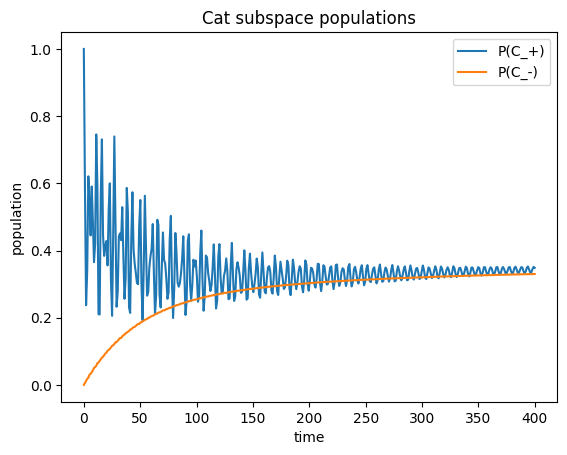

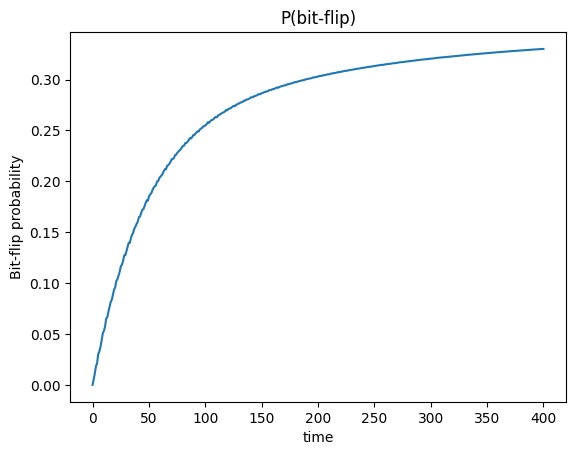

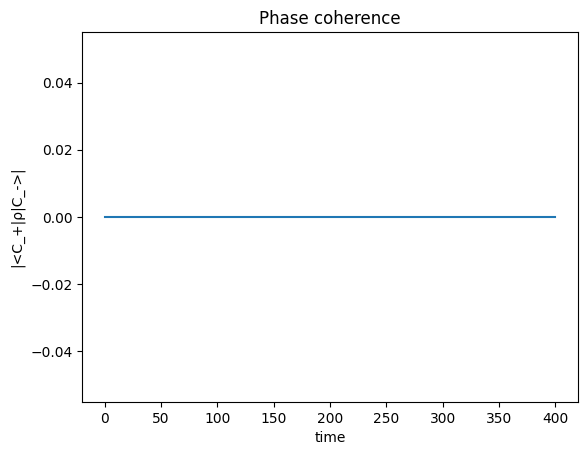

In [8]:
# --- QuTiP PCC: single-photon loss only ---
from qutip import *

# ---------- Physical parameters ----------
K = 1.0                 # Kerr nonlinearity (sets time units)
alpha = 2.0             # Cat amplitude; typically alpha = sqrt(P/K)
P = 2.0 #K * alpha**2        # Two-photon drive so that alpha = sqrt(P/K)
kappa = 5e-3 #1e-3            # Single-photon loss rate (dominant channel)

# Simulation control
nbar = alpha**2
N = max(20, int(np.ceil(nbar + 8*np.sqrt(max(nbar,1)))))  # heuristic cutoff
t_max = 2.0 / kappa      # long enough to see bit-flips (adjust as needed)
nt = 400
tlist = np.linspace(0.0, t_max, nt)

# ---------- Operators ----------
a = destroy(N)

# Pumped Kerr cavity Hamiltonian (rotating frame)
H = -K * a.dag()**2 * a**2 + P * (a**2 + a.dag()**2)

# Collapse operators: single-photon loss only
c_ops = [np.sqrt(kappa) * a]

# ---------- Initial state: + cat (|C_+>)
# |C_+> ∝ |alpha> + |-alpha>, normalized
ket_p = coherent(N, alpha)
ket_m = coherent(N, -alpha)
# Normalization factors for cat states:
N_plus = 1.0 / np.sqrt(2.0 * (1.0 + np.exp(-2.0 * abs(alpha)**2)))
N_minus = 1.0 / np.sqrt(2.0 * (1.0 - np.exp(-2.0 * abs(alpha)**2)))

C_plus = (ket_p + ket_m) * N_plus
C_minus = (ket_p - ket_m) * N_minus

rho0 = ket2dm(C_plus)    # start in logical |0_L> ≡ |C_+>

# ---------- Evolve ----------
result = mesolve(H, rho0, tlist, c_ops, [])

# ---------- Projectors onto the logical cat basis ----------
P_plus = C_plus * C_plus.dag()
P_minus = C_minus * C_minus.dag()

# ---------- Extract logical metrics ----------
Pplus_t = np.array([ (P_plus * result.states[i]).tr().real for i in range(nt) ])
Pminus_t = np.array([ (P_minus * result.states[i]).tr().real for i in range(nt) ])

# Bit-flip probability (starting in C_+): probability to be in C_- subspace
P_bitflip = Pminus_t

# A crude phase-flip indicator: loss of coherence between |±alpha|
# (You can also compute off-diagonal <C_+|ρ|C_-> directly.)
coh_plus_minus = np.array([
    (C_plus.dag() * result.states[i] * C_minus) for i in range(nt)
], dtype=complex)
phase_coherence = np.abs(coh_plus_minus)

# ---------- Optional quick plots (comment out if running headless) ----------
# import matplotlib.pyplot as plt
plt.figure(); plt.plot(tlist, Pplus_t, label='P(C_+)'); plt.plot(tlist, Pminus_t, label='P(C_-)');
plt.xlabel('time'); plt.ylabel('population'); plt.legend(); plt.title('Cat subspace populations'); plt.show()
plt.figure(); plt.plot(tlist, P_bitflip); plt.xlabel('time'); plt.ylabel('Bit-flip probability'); plt.title('P(bit-flip)'); plt.show()
plt.figure(); plt.plot(tlist, phase_coherence); plt.xlabel('time'); plt.ylabel('|<C_+|ρ|C_->|'); plt.title('Phase coherence'); plt.show()


In [9]:
import numpy as np
from scipy.optimize import curve_fit

def Pminus_model(t, GammaX, Pinf):
    # allow a small steady-state offset Pinf ≈ 0.5 (can be < 0.5 with drive)
    return Pinf * (1.0 - np.exp(-2.0 * GammaX * t))

# choose a fit window that skips the early oscillatory transient
# e.g., use the last 60% of samples — tweak as you like:
i0 = int(0.4 * len(tlist))
t_fit = tlist[i0:]
y_fit = Pminus_t[i0:]

p0 = [1e-3, 0.5]  # initial guess: GammaX ~ 1e-3, Pinf ~ 0.5
bounds = ([0.0, 0.0], [np.inf, 1.0])

GammaX_est, Pinf_est = curve_fit(Pminus_model, t_fit, y_fit, p0=p0, bounds=bounds)[0]
print(f"Estimated Gamma_X = {GammaX_est:.4e}  (P_inf ≈ {Pinf_est:.3f})")


Estimated Gamma_X = 6.3723e-03  (P_inf ≈ 0.329)


In [10]:
from qutip import *

# --- initial logical + state ---
rho0_plus = 0.5*(ket2dm(C_plus) + ket2dm(C_minus) + C_plus*C_minus.dag() + C_minus*C_plus.dag())

# (reuse H, c_ops, tlist, and the same stiff solver options you used)
from qutip.solver import Options
opts = Options(nsteps=100000, method='bdf', atol=1e-8, rtol=1e-6)
res_plus = mesolve(H, rho0_plus, tlist, c_ops, [], options=opts)

# coherence vs time: <C_+|ρ|C_->
coh_pm = np.array([
    complex(C_plus.dag() * res_plus.states[i] * C_minus) for i in range(len(tlist))
], dtype=complex)
coh_abs = np.abs(coh_pm)

# Fit A * exp(-GammaZ t) + C over a region after initial transient
def coh_model(t, A, GammaZ, C):
    return A * np.exp(-GammaZ * t) + C

j0 = int(0.1 * len(tlist))  # usually coherence is smooth; small skip is fine
t_fit2 = tlist[j0:]
y_fit2 = coh_abs[j0:]

p0 = [coh_abs[j0], 1e-4, 0.0]
bounds = ([0.0, 0.0, -0.05], [1.5, np.inf, 0.05])

A_est, GammaZ_est, C_est = curve_fit(coh_model, t_fit2, y_fit2, p0=p0, bounds=bounds)[0]
print(f"Estimated Gamma_Z = {GammaZ_est:.4e}  (A ≈ {A_est:.3f}, C ≈ {C_est:.3e})")


c:\Users\carl0\Documents\TRIBE\.venv\Lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


Estimated Gamma_Z = 1.8861e-05  (A ≈ 0.226, C ≈ 2.705e-02)


In [11]:
print(f"Noise bias (Gamma_X / Gamma_Z) ≈ {GammaX_est / GammaZ_est:.2e}")


Noise bias (Gamma_X / Gamma_Z) ≈ 3.38e+02
